# Decision Tree Classification

## Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

## Importing the data

In [3]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [4]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [5]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [6]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df["label"]=df.classification_diagnostic
df= df.drop(["classification_diagnostic"], axis=1 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quartier                 709 non-null    object 
 1   site                     709 non-null    object 
 2   cote_voirie              709 non-null    object 
 3   contrainte               709 non-null    object 
 4   genre_arbre              709 non-null    object 
 5   espece_arbre             709 non-null    object 
 6   situation                709 non-null    object 
 7   type_sol                 709 non-null    object 
 8   plaie_houppier           709 non-null    object 
 9   bois_mort_houppier       709 non-null    object 
 10  classe_age               709 non-null    object 
 11  ecorce_incluse_houppier  709 non-null    object 
 12  classe_hauteur           709 non-null    object 
 13  fissure_houppier         709 non-null    object 
 14  classe_circonference     7

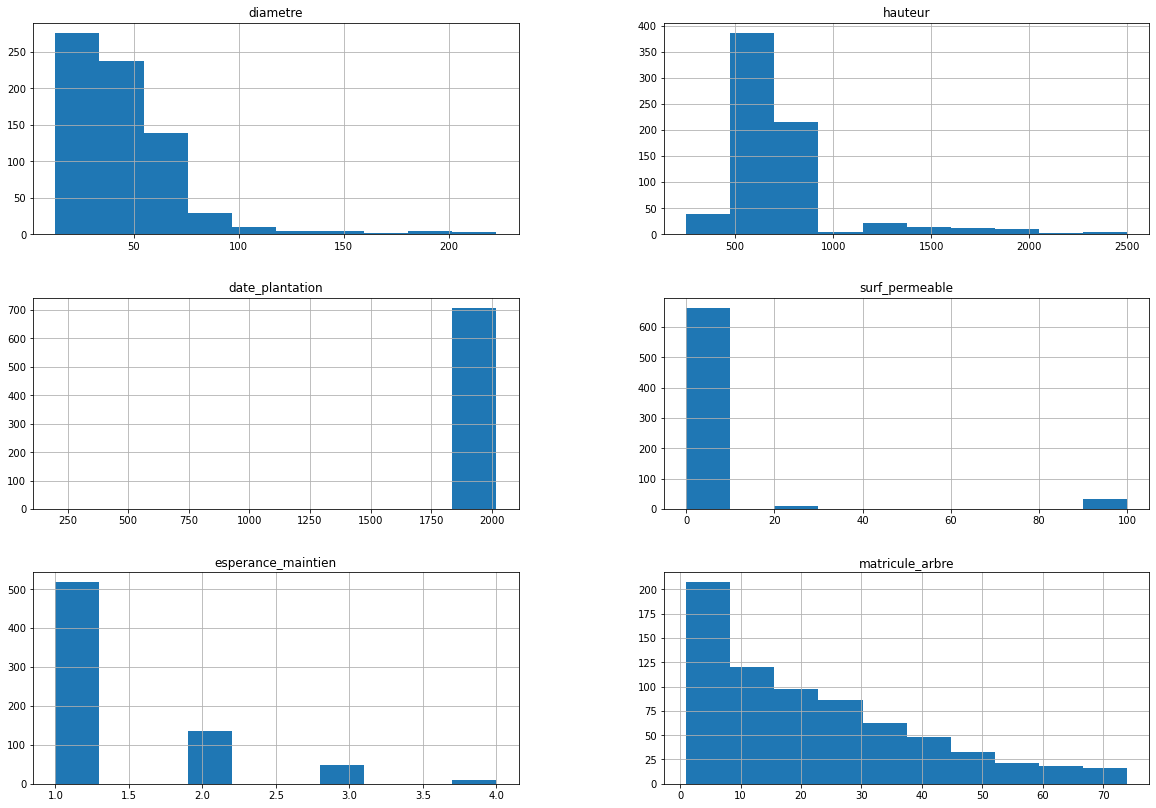

In [7]:
_ = df.hist(figsize=(20, 14))

In [8]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [9]:
df.nunique()

quartier                    6
site                       30
cote_voirie                 2
contrainte                  2
genre_arbre                26
espece_arbre               37
situation                   4
type_sol                    9
plaie_houppier              5
bois_mort_houppier          3
classe_age                  4
ecorce_incluse_houppier     2
classe_hauteur              5
fissure_houppier            3
classe_circonference        7
port_arbre                  5
vigueur_pousse              4
champignon_collet           2
plaie_collet                7
champignon_tronc            2
fissure_tronc               3
rejet_tronc                 2
tuteurage_arbre             4
canisse_arbre               2
plaie_tronc                 6
champignon_houppier         2
diametre                   42
hauteur                    17
date_plantation            13
surf_permeable              9
esperance_maintien          4
matricule_arbre            74
label                       5
dtype: int

In [10]:
df['label'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: label, dtype: int64

In [11]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [12]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [13]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [14]:
X

array([[0.0, 1.0, 0.0, ..., 5.0, 1.0, 7],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 8],
       [0.0, 1.0, 0.0, ..., 5.0, 1.0, 9],
       ...,
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 6],
       [1.0, 0.0, 0.0, ..., 1.0, 2.0, 7],
       [1.0, 0.0, 0.0, ..., 1.0, 1.0, 8]], dtype=object)

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [17]:
print(X.shape)
print(y.shape)

(709, 190)
(709,)


In [18]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [19]:
type(X)

numpy.ndarray

In [20]:
type(y)

numpy.ndarray

## Splitting the dataset into the Training set and Test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature Scaling

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 184:] = sc.fit_transform(X_train[:, 184:])
X_test[:, 184:]= sc.transform(X_test[:, 184:])

In [23]:
print(X_train)

[[0.0 0.0 1.0 ... -0.15122588648807314 -0.5525270842365981
  0.21618120010426706]
 [0.0 0.0 0.0 ... -0.29437292762119077 -0.5525270842365981
  -0.3389580229895707]
 [0.0 0.0 0.0 ... 4.429479429771692 2.4890540493765188
  -0.8385833237740247]
 ...
 [0.0 1.0 0.0 ... 0.6122249995552209 -0.5525270842365981
  -0.9496111683927921]
 [0.0 0.0 1.0 ... 4.429479429771692 2.4890540493765188
  -1.1161529353209434]
 [0.0 1.0 0.0 ... -0.3420886079988967 2.4890540493765188
  -0.2834441006801869]]


In [24]:
print(X_test)

[[0.0 0.0 1.0 ... -0.15122588648807314 -0.5525270842365981
  1.3819735686013264]
 [0.0 1.0 0.0 ... -0.29437292762119077 -0.5525270842365981
  -0.39447194529895446]
 [1.0 0.0 0.0 ... -0.29437292762119077 -0.5525270842365981
  -0.6165276345364895]
 ...
 [0.0 1.0 0.0 ... -0.15122588648807314 0.9682634825699604
  -0.7275554791552571]
 [0.0 1.0 0.0 ... -0.29437292762119077 -0.5525270842365981
  0.04963943317611574]
 [0.0 1.0 0.0 ... -0.2705150874323378 -0.5525270842365981
  -0.39447194529895446]]


## Decision Tree Model

## Training the Decision Tree Classification model on the Training set

In [25]:
%%time
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0, max_depth= 20)
classifier.fit(X_train, y_train)

Wall time: 19 ms


DecisionTreeClassifier(max_depth=20, random_state=0)

## Predicting the Test set results

In [26]:
y_pred = classifier.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

## Making the Confusion Matrix

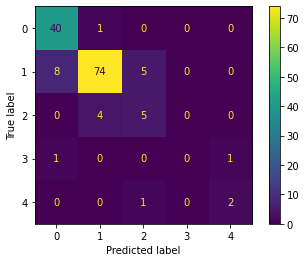

model accuracy: 0.852


In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [28]:
%%time
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 84.66 %
Standard Deviation: 3.08 %
Wall time: 33.1 ms


## Validation Curve

%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

In [28]:
# Create range of values for the hyperparameter
param_range= np.arange(1, 30, 1)

In [29]:
# Calculate accuracy on training and test data set through cross validation (on entire dataset, since sample size is small)
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(classifier,
                                  X_train, y_train, param_name="max_depth", param_range=param_range,
                                  cv=7, scoring="accuracy", n_jobs=-1)

In [30]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [31]:
for i in range(20):
    print("Maximum Depth= {:},".format(i+1),"Mean cross-validation score is {:.5f}".format(test_mean[i]))

Maximum Depth= 1, Mean cross-validation score is 0.74250
Maximum Depth= 2, Mean cross-validation score is 0.73721
Maximum Depth= 3, Mean cross-validation score is 0.76543
Maximum Depth= 4, Mean cross-validation score is 0.79365
Maximum Depth= 5, Mean cross-validation score is 0.79365
Maximum Depth= 6, Mean cross-validation score is 0.81481
Maximum Depth= 7, Mean cross-validation score is 0.81481
Maximum Depth= 8, Mean cross-validation score is 0.83951
Maximum Depth= 9, Mean cross-validation score is 0.84127
Maximum Depth= 10, Mean cross-validation score is 0.84303
Maximum Depth= 11, Mean cross-validation score is 0.83069
Maximum Depth= 12, Mean cross-validation score is 0.82540
Maximum Depth= 13, Mean cross-validation score is 0.83245
Maximum Depth= 14, Mean cross-validation score is 0.83598
Maximum Depth= 15, Mean cross-validation score is 0.82540
Maximum Depth= 16, Mean cross-validation score is 0.82540
Maximum Depth= 17, Mean cross-validation score is 0.82892
Maximum Depth= 18, Mean

In [32]:
for i in range(20):
    print("Maximum Depth= {:},".format(i+1),"Mean training score is {:.5f}".format(train_mean[i]))

Maximum Depth= 1, Mean training score is 0.74250
Maximum Depth= 2, Mean training score is 0.75309
Maximum Depth= 3, Mean training score is 0.79071
Maximum Depth= 4, Mean training score is 0.83069
Maximum Depth= 5, Mean training score is 0.87066
Maximum Depth= 6, Mean training score is 0.89212
Maximum Depth= 7, Mean training score is 0.91828
Maximum Depth= 8, Mean training score is 0.94239
Maximum Depth= 9, Mean training score is 0.96296
Maximum Depth= 10, Mean training score is 0.97825
Maximum Depth= 11, Mean training score is 0.98530
Maximum Depth= 12, Mean training score is 0.98854
Maximum Depth= 13, Mean training score is 0.99177
Maximum Depth= 14, Mean training score is 0.99442
Maximum Depth= 15, Mean training score is 0.99677
Maximum Depth= 16, Mean training score is 0.99882
Maximum Depth= 17, Mean training score is 0.99941
Maximum Depth= 18, Mean training score is 1.00000
Maximum Depth= 19, Mean training score is 1.00000
Maximum Depth= 20, Mean training score is 1.00000


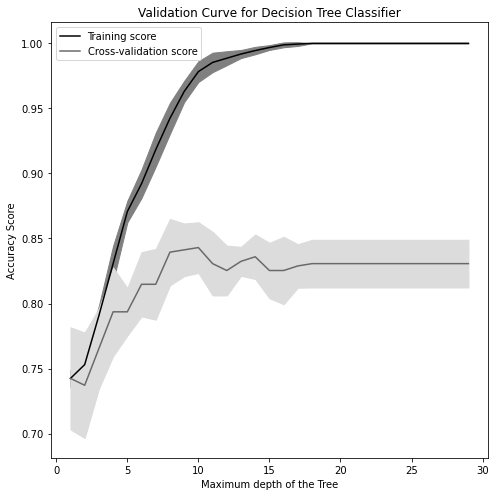

In [33]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.title("Validation Curve for Decision Tree Classifier")
plt.xlabel("Maximum depth of the Tree")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

## Learning curve

To understand the impact of the number of samples available for training on
the generalization performance of a predictive model, it is possible to
synthetically reduce the number of samples used to train the predictive model
and check the training and testing errors.

Therefore, we can vary the number of samples in the training set and repeat
the experiment. The training and testing scores can be plotted similarly to
the validation curve, but instead of varying a hyperparameter, we vary the
number of training samples. This curve is called the **learning curve**.

It gives information regarding the benefit of adding new training samples
to improve a model's generalization performance.

Let's compute the learning curve for a decision tree and vary the
proportion of the training set from 10% to 100%.

In [29]:
train_sizes = np.linspace(0.1, 1.0, num=10, endpoint=True)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state= 0)

In [31]:
from sklearn.model_selection import learning_curve
results = learning_curve(
    classifier, X, y, train_sizes=train_sizes, cv=cv,
    scoring="accuracy", n_jobs=-1)
train_size, train_scores, test_scores = results[:3]
# Convert the scores into errors
train_errors, test_errors = train_scores, test_scores

Text(0.5, 1.0, 'Learning curve')

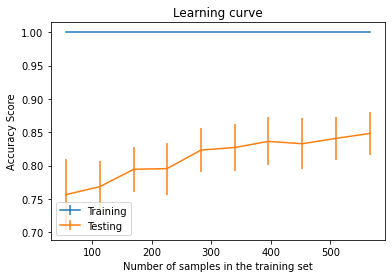

In [33]:
plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Testing")
plt.legend()
#plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy Score")
plt.title("Learning curve")

## Post pruning decision trees with cost complexity pruning
Total impurity of leaves vs effective alphas of pruned tree
Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [38]:
classifier = DecisionTreeClassifier(random_state=0, criterion= "entropy")
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

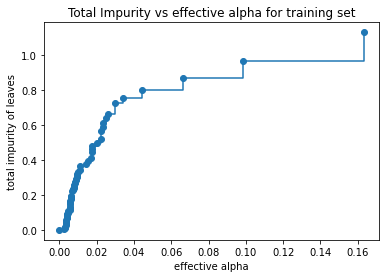

In [39]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [40]:
classifiers = []
for ccp_alpha in ccp_alphas:
    classifier = DecisionTreeClassifier(random_state=0, criterion="entropy", ccp_alpha=ccp_alpha)
    classifier.fit(X_train, y_train)
    classifiers.append(classifier)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        classifiers[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2828071340363698


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

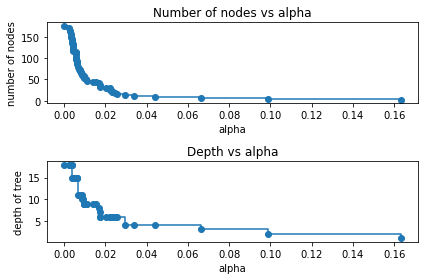

In [41]:
classifiers = classifiers[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [classifier.tree_.node_count for classifier in classifiers]
depth = [classifier.tree_.max_depth for classifier in classifiers]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Accuracy vs alpha for training and testing sets
When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ccp_alpha=0.015 maximizes the testing accuracy.

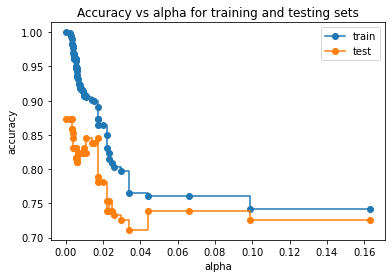

In [42]:
train_scores = [classifier.score(X_train, y_train) for classifier in classifiers]
test_scores = [classifier.score(X_test, y_test) for classifier in classifiers]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

## Resampling

from sklearn.utils import resample
X, y = resample(X, y, stratify=y, n_samples= 2000, random_state=0)

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

## AdaBoost Validation Curve

In [43]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import validation_curve
from sklearn.ensemble import AdaBoostClassifier

Wall time: 2h 13min 44s


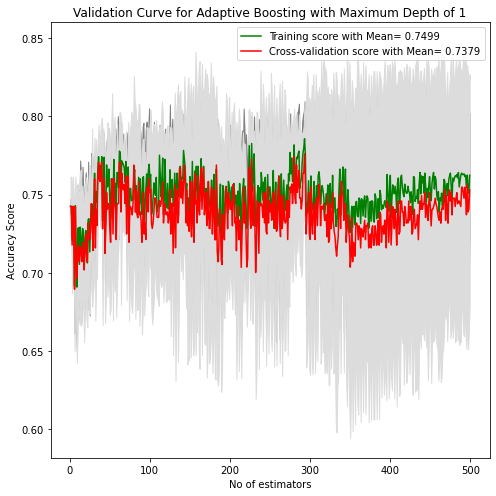

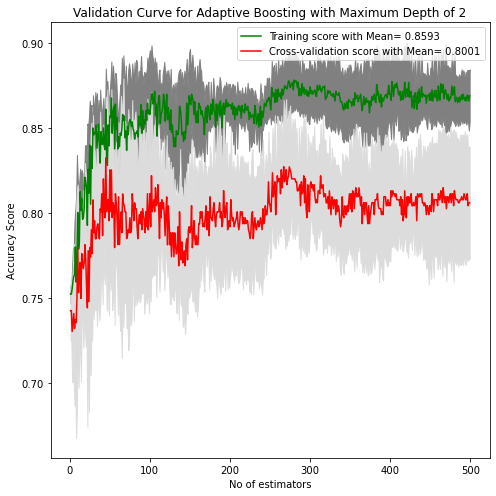

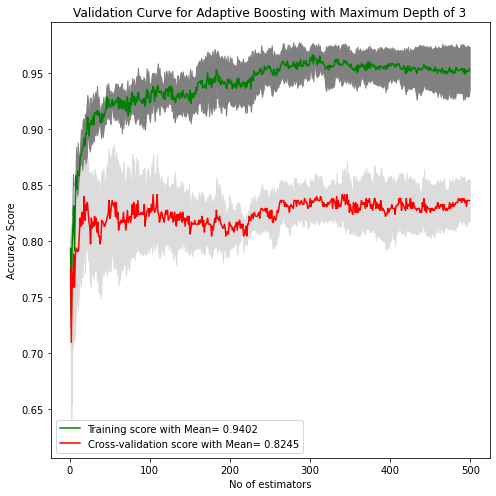

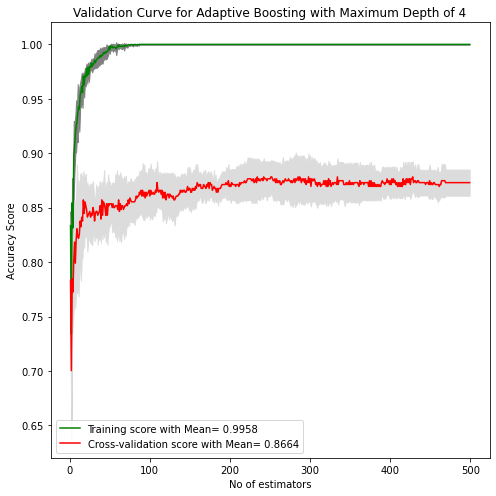

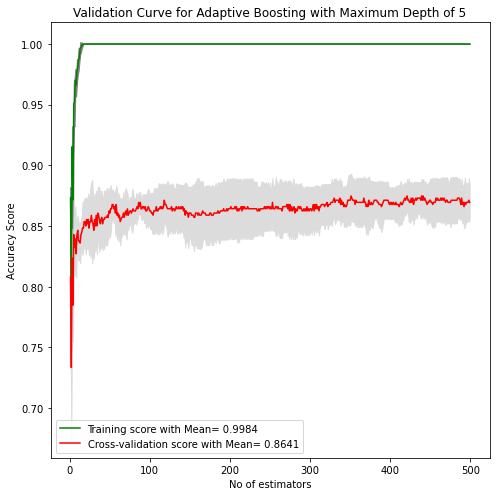

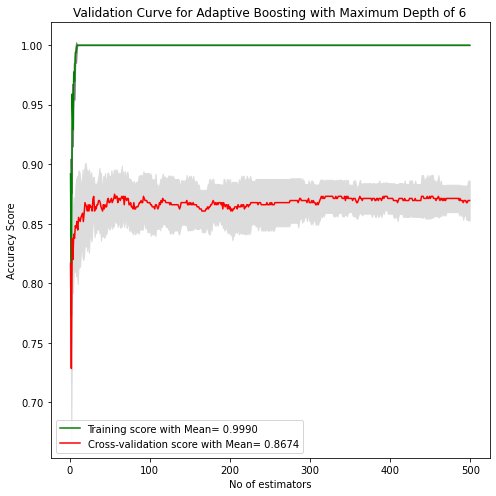

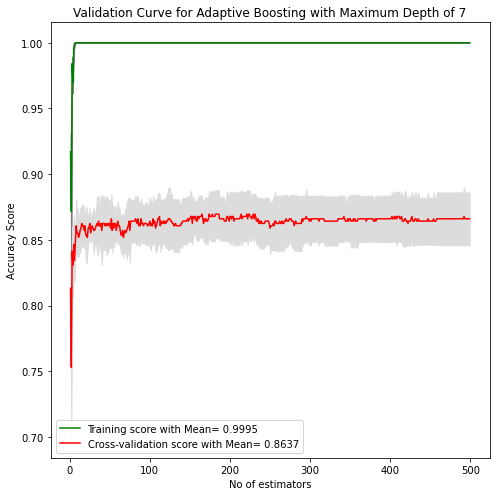

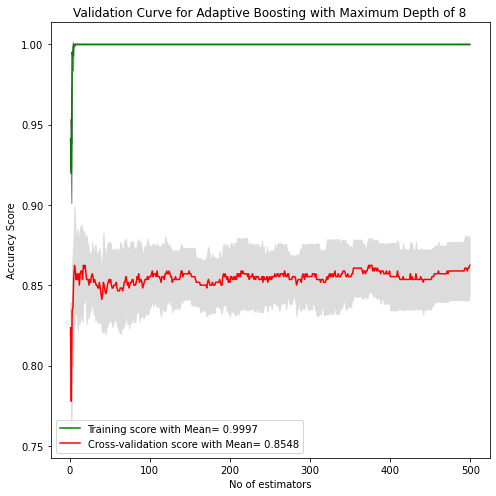

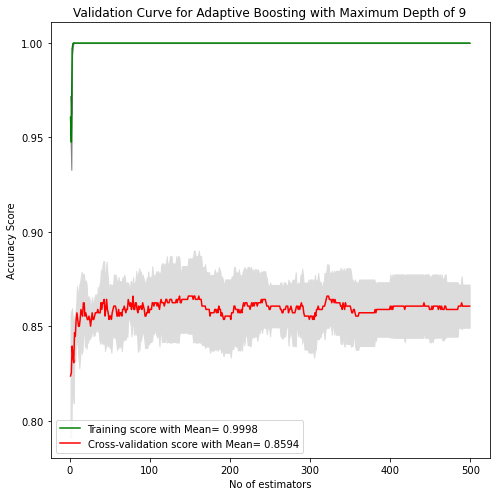

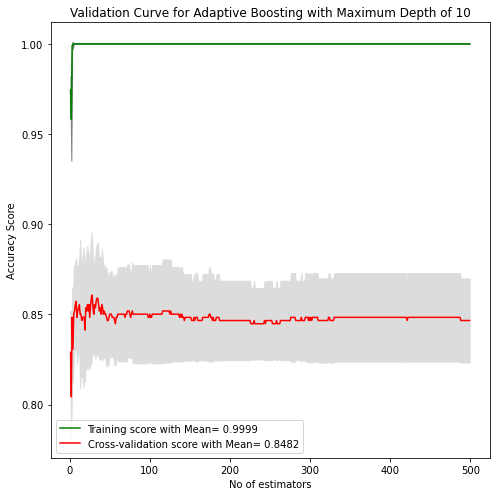

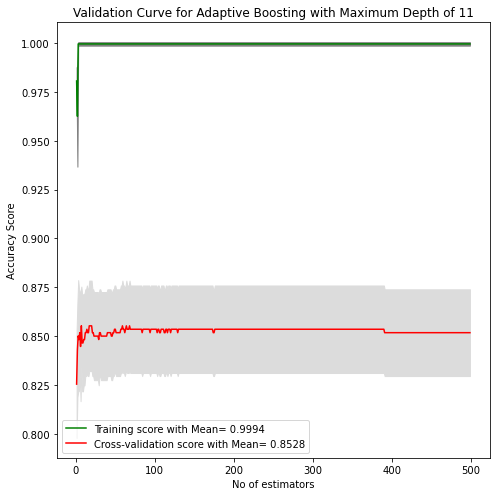

In [44]:
%%time
# Create range of values for the hyperparameter
param_range= np.arange(1, 500, 1)
# Calculate accuracy on training and test data set through cross validation (on entire dataset, since sample size is small)

for i in range(11):
    base_estimator = DecisionTreeClassifier(max_depth=i+1, random_state=0)
    classifier = AdaBoostClassifier(base_estimator= base_estimator, algorithm= "SAMME", random_state=0)
    classifier.fit(X_train, y_train)
    #y_pred = classifier.predict(X_test)
    train_scores, test_scores = validation_curve(classifier,
                                                 X_train, y_train, param_name="n_estimators", param_range=param_range,
                                                 cv=5, scoring="accuracy", n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.subplots(1, figsize=(7,7))
    plt.plot(param_range, train_mean, label="Training score with Mean= {:.4f}".format(train_mean.mean()), color="green")
    plt.plot(param_range, test_mean, label="Cross-validation score with Mean= {:.4f}".format(test_mean.mean()), color="red")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
    plt.title("Validation Curve for Adaptive Boosting with Maximum Depth of {:}".format(i+1))
    plt.xlabel("No of estimators")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    #plt.show()
    plt.savefig("ABVCFDepth" + str(i+1))